In [1]:
from plyfile import PlyData, PlyElement

import math
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
plt.rcParams['legend.fontsize'] = 2
plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
max_sh_degree = 3

In [5]:
root = "/home/loyot/workspace/code/gaussian-splatting/output/coffee_martini_dy_v2/0/point_cloud/iteration_10000/point_cloud.ply"
xyz_0 = load_ply(root)
root = "/home/loyot/workspace/code/gaussian-splatting/output/coffee_martini_dy_v2/1/point_cloud/iteration_2000/point_cloud.ply"
xyz_1 = load_ply(root)

In [6]:
xyz_0.shape

(441980, 3)

In [7]:
xyz_1.shape

(443721, 3)

In [3]:
# read ply file
import glob
root = "/home/loyot/workspace/code/gaussian-splatting/output/coffee_martini/*/point_cloud/iteration_2000/*.ply"
ply_list = glob.glob(root)

import re
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

ply_list.sort(key=natural_keys)

In [4]:
def load_ply(path):
    plydata = PlyData.read(path)

    xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                    np.asarray(plydata.elements[0]["y"]),
                    np.asarray(plydata.elements[0]["z"])),  axis=1)
        
    return xyz

In [5]:
import tqdm
xyzs_list = []
for i in tqdm.tqdm(range(len(ply_list))):
    xyzs_list.append(load_ply(ply_list[i]))

100%|██████████| 299/299 [00:14<00:00, 20.62it/s]


In [6]:
xyzs_list_numpy = np.stack(xyzs_list)
xyzs_list_torch = torch.from_numpy(xyzs_list_numpy)
xyzs_dist = xyzs_list_torch - xyzs_list_torch.mean(dim=0, keepdim=True)
sorted, indice = torch.sort(torch.abs(xyzs_dist).sum(0).sum(-1))

In [7]:
class Fitting_polynomial(torch.nn.Module):
    def __init__(self, dim):

        super(Fitting_polynomial,self).__init__()
        self.param = torch.nn.Parameter(torch.randn((dim, )))


    def forward(self, x):

        y = 0.
        for i in range(self.param.size(0)):
            y += self.param[i] * x ** i

        return y

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        string = 'y = '
        for i in range(self.param.size(0)):
            if i == (self.param.size(0)-1):
                string += f'{self.param[i].item()} x^{i}'
            else:
                string += f'{self.param[i].item()} x^{i} + '
        return string

    def plot_poly(self,x):
        
        fig = plt.figure(figsize=(14,8))
        y = 0.
        for i in range(self.param.size(0)):
            y += self.param[i] * x ** i
        y = y.detach().numpy()
        plt.plot(x,y,label="fitting")
        plt.legend()

In [8]:
def get_dim_model(y_target, x, dim=9):
    # Create Tensors to hold input and outputs.
    y = torch.from_numpy(y_target)

    # Construct our model by instantiating the class defined above
    model = Fitting_polynomial(dim)

    criterion = torch.nn.SmoothL1Loss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    for t in tqdm.tqdm(range(100000)):
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x)

        # Compute and print loss
        loss = criterion(y_pred, y)
        # if t % 2000 == 1999:
        #     print("epoch:{},mse:{}".format(t+1, loss.item()))
        #     print(f'Result: {model.string()}')
        #     plt.plot(x,y,label="raw")
        #     plt.legend()
        #     model.plot_poly(x)
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return model

In [9]:
# test fitting 
point_id = indice[-1]
x = torch.linspace(0, 1, 299)
x_target = xyzs_list_numpy[:, point_id, 0]
y_target = xyzs_list_numpy[:, point_id, 1]
z_target = xyzs_list_numpy[:, point_id, 2]

x_model = get_dim_model(x_target, x)
y_model = get_dim_model(y_target, x)
z_model = get_dim_model(z_target, x)

100%|██████████| 100000/100000 [00:18<00:00, 5295.19it/s]


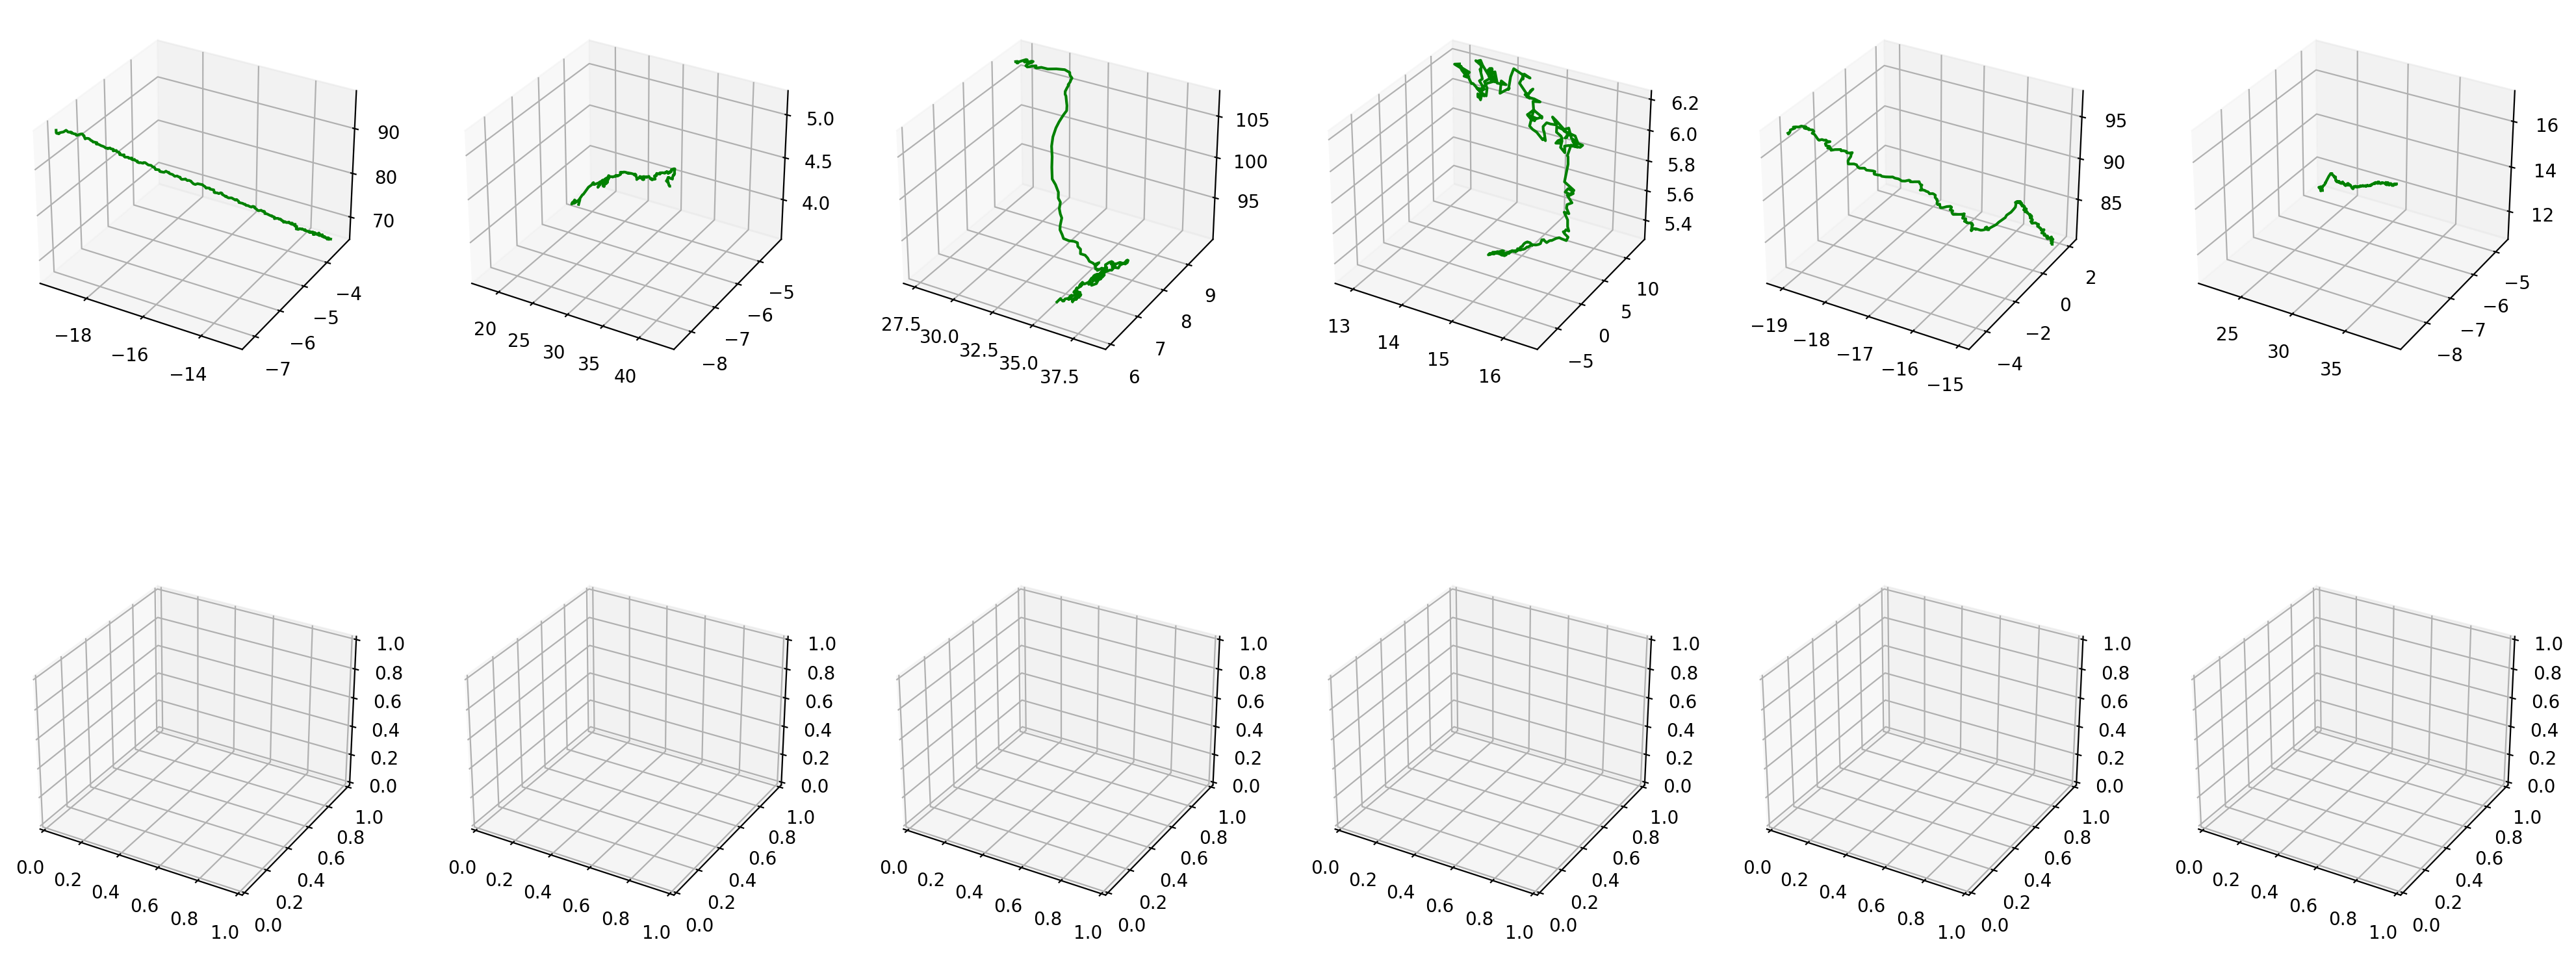

In [21]:
num_curve = 6
fig, axs = plt.subplots(nrows=2, ncols=num_curve, subplot_kw={'projection': '3d'})

# plot raw curve
for idx in range(1, num_curve+1):
    point_id = indice[-idx]
    x = xyzs_list_numpy[:, point_id, 0]
    y = xyzs_list_numpy[:, point_id, 1]
    z = xyzs_list_numpy[:, point_id, 2]
    axs[0, idx-1].plot(x, y, z, color='g')

plt.show()

training curve: 1


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:18<00:00, 5348.76it/s]


training curve: 2


100%|██████████| 100000/100000 [00:18<00:00, 5377.08it/s]


training curve: 3


100%|██████████| 100000/100000 [00:18<00:00, 5370.41it/s]


training curve: 4


100%|██████████| 100000/100000 [00:18<00:00, 5333.48it/s]


training curve: 5


100%|██████████| 100000/100000 [00:18<00:00, 5373.69it/s]


training curve: 6


100%|██████████| 100000/100000 [00:18<00:00, 5354.99it/s]


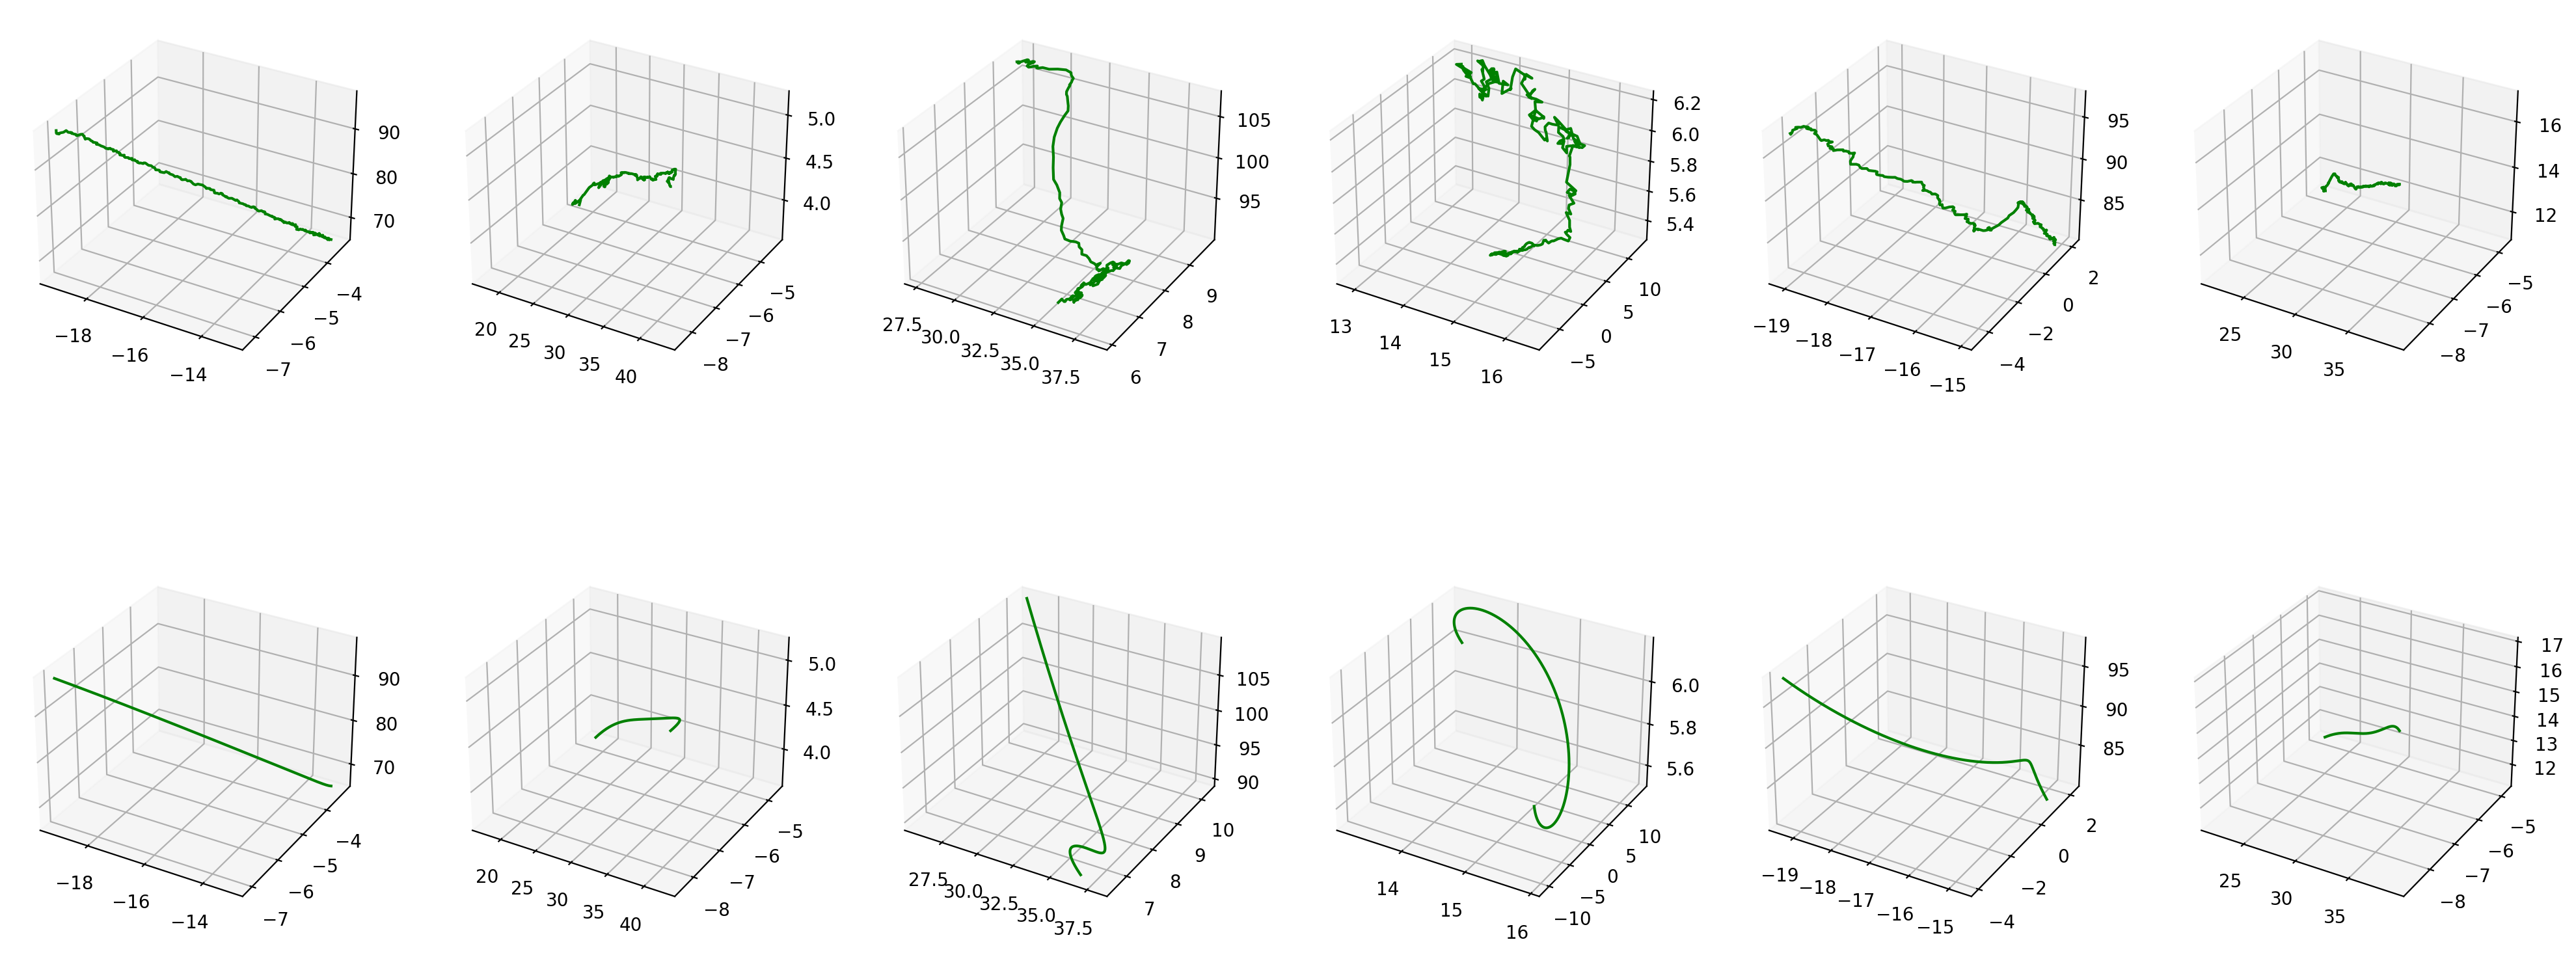

In [22]:
num_curve = 6
fig, axs = plt.subplots(nrows=2, ncols=num_curve, subplot_kw={'projection': '3d'})

# plot raw curve
for idx in range(1, num_curve+1):
    point_id = indice[-idx]
    x = xyzs_list_numpy[:, point_id, 0]
    y = xyzs_list_numpy[:, point_id, 1]
    z = xyzs_list_numpy[:, point_id, 2]
    axs[0, idx-1].plot(x, y, z, color='g')
    # axs[0, idx].set_title(f'raw curve {idx}')
    
# train polynomial to fit curve
for idx in range(1, num_curve+1):
    print(f"training curve: {idx}")
    point_id = indice[-idx]
    x = torch.linspace(0, 1, 299)
    x_target = xyzs_list_numpy[:, point_id, 0]
    y_target = xyzs_list_numpy[:, point_id, 1]
    z_target = xyzs_list_numpy[:, point_id, 2]

    x_model = get_dim_model(x_target, x)
    y_model = get_dim_model(y_target, x)
    z_model = get_dim_model(z_target, x)
    axs[1, idx-1].plot(
        x_model(x).cpu().detach().numpy(), 
        y_model(x).cpu().detach().numpy(), 
        z_model(x).cpu().detach().numpy(), 
        color='g'
    )
    # axs[1, idx].set_title(f'fitting curve {idx}')

plt.show()

In [23]:
import taichi as ti
ti.init(arch=ti.cuda)

@ti.kernel
def poly_kernel_fwd(factors: ti.types.ndarray(), t: ti.types.ndarray(), out: ti.types.ndarray()):
    for pid, dim_id, f_id in ti.ndrange(factors.shape[0], factors.shape[1], factors.shape[2]):
        out[pid, dim_id] += factors[pid, dim_id, f_id] * (t[pid] ** f_id)
        
@ti.kernel
def poly_kernel_bwd(d_factors: ti.types.ndarray(), t: ti.types.ndarray(), d_out: ti.types.ndarray()):
    for pid, dim_id, f_id in ti.ndrange(d_factors.shape[0], d_factors.shape[1], d_factors.shape[2]):
        d_factors[pid, dim_id, f_id] = d_out[pid, dim_id] * (t[pid] ** f_id)
        
class _polynomial_taichi(torch.autograd.Function):
    @staticmethod
    def forward(ctx, factors, t):
        ctx.save_for_backward(factors, t)
        out = torch.empty(
            (factors.shape[0], factors.shape[1]), 
            dtype=torch.float32, 
            device=factors.device
        )
        poly_kernel_fwd(factors, t, out)
        return out
    
    @staticmethod
    def backward(ctx, d_out):
        factors, t = ctx.saved_tensors
        d_factors = torch.empty_like(factors)
        poly_kernel_bwd(d_factors, t, d_out)
        return d_factors, None
        
        
class Polynomial_taichi(torch.nn.Module):
    def __init__(self, num_points, dim, max_degree):
        super(Polynomial_taichi,self).__init__()
        self.dim = dim
        self.max_degree = max_degree
        self.factors = torch.nn.Parameter(
            torch.randn(
                (num_points, dim, max_degree),
                dtype=torch.float32,
            ).requires_grad_(True)
        )
        
    def forward(self, x):
        return _polynomial_taichi.apply(self.factors, x)
    

[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.9


[I 09/10/23 03:25:12.148 3195785] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=cuda


In [35]:
point_id = indice[-1]
t = torch.linspace(0, 1, 299)
xyz_target = torch.from_numpy(xyzs_list_numpy[:, point_id, :])

Poly = Polynomial_taichi(1, 3, 9)

criterion = torch.nn.SmoothL1Loss(reduction='mean')
optimizer = torch.optim.SGD(Poly.parameters(), lr=1e-2, momentum=0.9)
        
progress_bar = tqdm.tqdm(range(30000), desc="Training progress")
for b in range(30000):
    random_id = torch.randint(0, 299, ())
    t_i = t[random_id][None]
    y_target = xyz_target[random_id:random_id+1, :]
    y_pre = Poly(t_i)
    loss = criterion(y_pre, y_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if b % 10 == 0:
        progress_bar.set_postfix({"loss": loss.item()})
        progress_bar.update(10)
progress_bar.close()

Training progress: 100%|█████████▉| 29999/30000 [03:15<00:00, 1676.56it/s, loss=0.137]   

Training progress: 100%|██████████| 30000/30000 [03:30<00:00, 1676.56it/s, loss=0.137]

In [28]:
y_target

array([[-15.24482 ,  -4.578985,  76.519264]], dtype=float32)

In [36]:
y_pre = Poly(torch.tensor([0.]))

In [37]:
y_pre

tensor([[-1.9565e+01, -7.0485e+00,  2.0789e+11]],
       grad_fn=<_polynomial_taichiBackward>)

In [38]:
xyz_target[0, :]

tensor([-19.2328,  -7.1422,  97.5744])